# 3.5 图像分类数据集

(**MNIST数据集**) :cite:`LeCun.Bottou.Bengio.ea.1998`
(**是图像分类中广泛使用的数据集之一，但作为基准数据集过于简单。
我们将使用类似但更复杂的Fashion-MNIST数据集**) :cite:`Xiao.Rasul.Vollgraf.2017`。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## 1 读取数据集

我们可以[**通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中**]。


In [2]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True
)

Fashion-MNIST由10个类别的图像组成，
每个类别由*训练数据集*（train dataset）中的6000张图像
和*测试数据集*（test dataset）中的1000张图像组成。
因此，训练集和测试集分别包含60000和10000张图像。
测试数据集不会用于训练，只用于评估模型性能。


In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

每个输入图像的高度和宽度均为28像素。
数据集由灰度图像组成，其通道数为1。
为了简洁起见，本书将高度$h$像素、宽度$w$像素图像的形状记为$h \times w$或（$h$,$w$）。


In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。
以下函数用于在数字标签索引及其文本名称之间进行转换。


In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

我们现在可以创建一个函数来可视化这些样本。


In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

以下是训练数据集中前[**几个样本的图像及其相应的标签**]。


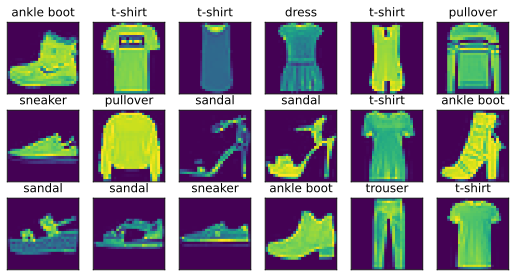

In [7]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 3, 6, titles=get_fashion_mnist_labels(y));

---
## 2 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建。
回顾一下，在每次迭代中，数据加载器每次都会[**读取一小批量数据，大小为`batch_size`**]。
通过内置数据迭代器，我们可以随机打乱了所有样本，从而无偏见地读取小批量。


In [8]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

我们看一下读取训练数据所需的时间。


In [9]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'10.88 sec'

---
## 3 整合所有组件

现在我们[**定义`load_data_fashion_mnist`函数**]，用于获取和读取Fashion-MNIST数据集。
这个函数返回训练集和验证集的数据迭代器。
此外，这个函数还接受一个可选参数`resize`，用来将图像大小调整为另一种形状。


In [10]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

下面，我们通过指定`resize`参数来测试`load_data_fashion_mnist`函数的图像大小调整功能。


torch.Size([32, 1, 100, 100]) torch.float32 torch.Size([32]) torch.int64


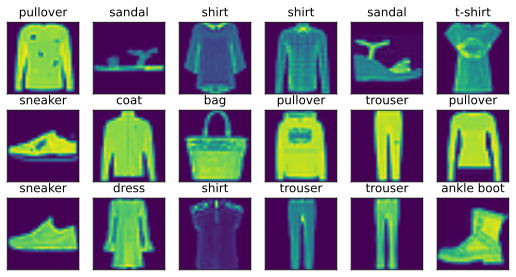

In [16]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=100)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    show_images(X.reshape(-1, 100, 100), 3, 6, get_fashion_mnist_labels(y))
    break

我们现在已经准备好使用Fashion-MNIST数据集，便于下面的章节调用来评估各种分类算法。

---

## 4 小结

* Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
* 我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或（$h$,$w$）。
* 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。

---

## 5 练习

1. 减少$batch\_size$（如减少到1）是否会影响读取性能？

    如果是在外存中，肯定是影响的，如果是在内容中，感觉没有区别。

    较大的$batch\_size$可以利用并行化操作来提高数据加载的效率。在读取数据时，可以同时加载多个样本到内存中，以减少磁盘读取数据的时间。而当$batch\_size$减少到1时，无法利用并行化操作，每次只能加载一个样本，从而导致数据加载的效率降低。

    此外，较小的$batch\_size$也会带来更多的数据加载次数。数据加载在计算机中属于I/O操作，通常是相对较慢的。因此，较小的$batch\_size$会导致更频繁的数据加载操作，增加了整体的读取时间。

    然而，较小的$batch\_size$也具有一些优点，比如更快的模型更新和更精确的梯度估计。因此，在选择$batch\_size$时，需要综合考虑性能和模型训练的需求，权衡不同因素。

2. 数据迭代器的性能非常重要。当前的实现足够快吗？探索各种选择来改进它。

   1. 使用`pin_memory=True`：在创建数据加载器时，设置`pin_memory=True`来将数据加载到GPU内存中，利用GPU的并行性来加快数据传输速度。
   
   2. 使用多个`get_dataloader_workers`：通过增加`get_dataloader_workers`参数的值，可以使用多个子进程或线程来并行读取数据，从而加快数据加载的速度。可以根据计算机的硬件配置和数据加载的需求，选择合适的`get_dataloader_workers`值。

3. 查阅框架的在线API文档。还有哪些其他数据集可用？

    例如 ImageNet、Qmnist 和 Kinetics-400。

[Discussions](https://discuss.d2l.ai/t/1787)
